In [ ]:
#installing and importing all necessary libraries
#pandas_ta is python's library for technical indicators

!pip install pandas_ta
!pip3 install keras-tuner
!pip install -U kera tensorflow
!pip install -q -U keras_tuner

!pip install gdown
!pip install tensorflow-gpu
!pip install tensorflow.keras
!pip install pickle

!pip install tensorflow==2.7.0

import pandas as pd
import numpy as np
from numpy import unique

#tecnical indicator library
import pandas_ta as ta

#date/time library
from datetime import datetime, timedelta

#Data visualisation
import plotly.graph_objs as go
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Machine/Deep learning libraries
import tensorflow as tf
#from tensorflow.keras.backend.tensorflow_backend import set_session
from tensorflow.compat.v1.keras.backend import set_session
#physical_devices = tf.config.list_physical_devices('GPU')
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#tf.config.gpu.set_per_process_memory_growth(True)
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
#set_session(sess)

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,Activation, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector
#from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


import keras_tuner
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters
import time
LOG_DIR =f"{int(time.time())}"



from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, log_loss, f1_score, mean_absolute_error, mean_squared_error

import joblib
from joblib import load, dump

import pickle
#from pickle import dumb,load

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#These are the different asset classes for which predictions will be carried out on
#It comprises of 5 major currency pair, 3 crosses and 2 exotics. 2 American stock indices
#1 Asian Pacific indice, 1 European indice. 2 crypto currencies, 2 metals and 2 commodities


#tickers = ['EURUSD', 'USDCAD', 'GBPAUD', 'EURCAD','EURGBP','ZARJPY', 'USDMXN' 
 #          'US30', 'UK100', 'AUS200', 'SPX500', 'BTCUSD', 'ETHUSD', 'XAUUSD', 'XAGUSD', 'BRENT CRUDE OIL', 'COCOA']

In [ ]:
#load in the historical data
pair ='EURUSD'

ticker = '/content/drive/MyDrive/Colab Notebooks/Historical FX Dataset/EURUSD.csv'

#df = pd.read_csv(ticker, index_col='Gmt time', parse_dates=['Gmt time'])

df = pd.read_csv(ticker)
df.tail()


,Gmt time,Open,High,Low,Close,Volume
3738,27.03.2022 00:00:00.000,1.09905,1.09914,1.09776,1.09818,8996.0756
3739,28.03.2022 00:00:00.000,1.09818,1.09998,1.09448,1.09915,208515.9090
3740,29.03.2022 00:00:00.000,1.09916,1.11373,1.09691,1.10914,296732.7895
3741,30.03.2022 00:00:00.000,1.10914,1.11712,1.10881,1.11615,215092.6200
3742,31.03.2022 00:00:00.000,1.11617,1.11852,1.10611,1.10731,191495.8345


In [ ]:
df.info()

In [ ]:
#creates a new copy of the dataframe with volume > 0
#when volume = 0, these are weekends when the markets are closed
df = df[df.Volume > 0].copy()
df.loc[(df["Volume"] == 0 )]

,Gmt time,Open,High,Low,Close,Volume


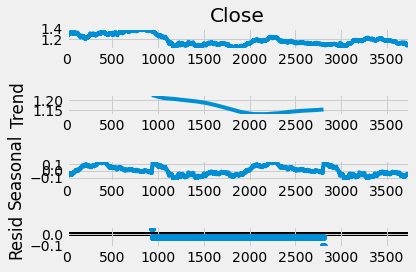

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Close'], period=1600)
#fig = fig_size(figure(10,15))
results.plot();

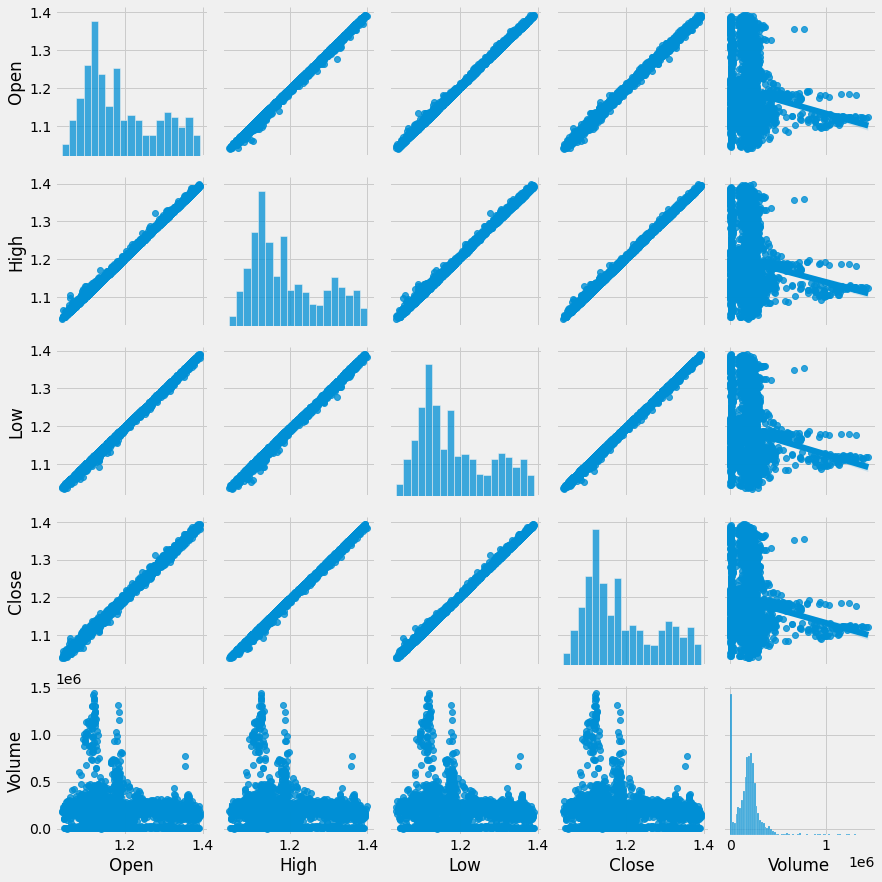

In [ ]:
import seaborn as sns
sns.pairplot(df, kind='reg')

In [ ]:
#check for missing rows/values
df.isna().sum()

Gmt time    0
Open        0
High        0
Low         0
Close       0
Volume      0
dtype: int64

In [ ]:
#add a column for previous close and volume
#The High/Low Indicator is a simple Indicator to compare current price with the previous session. 
#Usually, when prices are inside the previous session range, it can mean that the market is ranging.
#If the price is outside of the previous session, it can be trending

#Also knowing the previous volume traded at a particular price will help us to know where price may likely retest
#as these areas usually have some magnetising draws on price

'''df['Prev_Open'] = df.Open.shift(1)
df['Prev_High'] = df.High.shift(1)
df['Prev_Low'] = df.Low.shift(1)
df['Prev_Close'] = df.Close.shift(1)
df['Prev_Volume'] = df.Volume.shift(1)
df.head()'''

"df['Prev_Open'] = df.Open.shift(1)\ndf['Prev_High'] = df.High.shift(1)\ndf['Prev_Low'] = df.Low.shift(1)\ndf['Prev_Close'] = df.Close.shift(1)\ndf['Prev_Volume'] = df.Volume.shift(1)\ndf.head()"

In [ ]:
#MACD calculation function
def calc_macd(data, len1, len2, len3):
    shortEMA = data.ewm(span=len1, adjust=False).mean()
    longEMA = data.ewm(span=len2, adjust=False).mean()
    MACD = shortEMA - longEMA
    signal = MACD.ewm(span=len3, adjust=False).mean()
    return MACD, signal

In [ ]:
#add indicators to use using the pandas_ta
#or define functions to manually calculate the indicators
#add some price action candlestick patterns to (Engulfing candles, Hammer, Pinbar)
#IF THERE IS A WAY TO DO FUNDAMENTAL ANALYSIS using VADER and RE python modules too and add to dataframe

df['Prev_Close'] = df.Close.shift(1)

#df[HA_Close] = mean(df[['Open','High', 'Low', 'Close']])

#add exponential moving average
#These are TREND indicators measuring the direction and strength of a trend
df['EMA3'] = df.ta.ema(length=3)
df['EMA8'] = df.ta.ema(length=8)

#Standard deviation is a measure of variance, if standard deviation is high, it is a measure that the market is volatile
#df['STD20'] = df['Close'].rolling(20).std()

#The Average True Range(ATR) indicator is a VOLATILITY based indicator showing the degree of price movement
df['ATR'] = df.ta.atr(length=5)

#On Balance Volume (OBV) is a cumulative indicator 
#to measure buying and selling pressure.
df['OBVolume'] = df.ta.obv()     #calculated on the cv only

#add RSI
df.ta.rsi(length=14, append=True)

#MACD: Moving Average Convergence Divergence
#A momentum indicator; also reveals the changes in strength and direction
MACD, signal = calc_macd(df['Prev_Close'], 12, 26, 9)
df['MACD'] = MACD
df['MACD_signal'] = signal

df.tail()

,Gmt time,Open,High,Low,Close,Volume,Prev_Close,EMA3,EMA8,ATR,OBVolume,RSI_14,MACD,MACD_signal
3738,27.03.2022 00:00:00.000,1.09905,1.09914,1.09776,1.09818,8996.0756,1.09842,1.099035,1.100362,0.006071,-2.885636e+06,42.120201,-0.004468,-0.005737
3739,28.03.2022 00:00:00.000,1.09818,1.09998,1.09448,1.09915,208515.9090,1.09818,1.099092,1.100093,0.005956,-2.677120e+06,43.272843,-0.004398,-0.005470
3740,29.03.2022 00:00:00.000,1.09916,1.11373,1.09691,1.10914,296732.7895,1.09915,1.104116,1.102103,0.008129,-2.380387e+06,53.535641,-0.004215,-0.005219
3741,30.03.2022 00:00:00.000,1.10914,1.11712,1.10881,1.11615,215092.6200,1.10914,1.110133,1.105225,0.008165,-2.165295e+06,59.123955,-0.003227,-0.004820
3742,31.03.2022 00:00:00.000,1.11617,1.11852,1.10611,1.10731,191495.8345,1.11615,1.108722,1.105688,0.009014,-2.356790e+06,50.822802,-0.001857,-0.004228


In [ ]:

'''#Average Directional Movement (ADX) is meant to quantify TREND STRENGTH by measuring
#the amount of movement in a single direction.
df.ta.adx(length = 5, append=True)



#Chaikin Money Flow (CMF) uses volume in combination with recent price movements 
#to determine trends and to determine whether a market is overbought or oversold
df.ta.cmf(append=True)           #calculated based on the ohlcv



#Calculating Bollinger Band
# calculating individual components of Bollinger Bands
df['SMA_20'] = df['Close'].rolling(20).mean()
df['Upper_band_20'] = df['SMA_20'] + 2 * df['STD20']
df['Lower_band_20'] = df['SMA_20'] - 2 * df['STD20']


#add rsi and tsi
df.ta.tsi(append=True)


#add ichimoku
#it offers multiple tests on the price action, creating higher probability trades.
#df.ta.ichimoku (append=True)

#add a performance indicator: the logarithmic return 
df.ta.log_return(append=True)

df.columns
df.head()'''

"#Average Directional Movement (ADX) is meant to quantify TREND STRENGTH by measuring\n#the amount of movement in a single direction.\ndf.ta.adx(length = 5, append=True)\n\n\n\n#Chaikin Money Flow (CMF) uses volume in combination with recent price movements \n#to determine trends and to determine whether a market is overbought or oversold\ndf.ta.cmf(append=True)           #calculated based on the ohlcv\n\n\n\n#Calculating Bollinger Band\n# calculating individual components of Bollinger Bands\ndf['SMA_20'] = df['Close'].rolling(20).mean()\ndf['Upper_band_20'] = df['SMA_20'] + 2 * df['STD20']\ndf['Lower_band_20'] = df['SMA_20'] - 2 * df['STD20']\n\n\n#add rsi and tsi\ndf.ta.tsi(append=True)\n\n\n#add ichimoku\n#it offers multiple tests on the price action, creating higher probability trades.\n#df.ta.ichimoku (append=True)\n\n#add a performance indicator: the logarithmic return \ndf.ta.log_return(append=True)\n\ndf.columns\ndf.head()"

In [ ]:
df.isna().sum()

Gmt time        0
Open            0
High            0
Low             0
Close           0
Volume          0
Prev_Close      1
EMA3            2
EMA8            7
ATR             5
OBVolume        0
RSI_14         14
MACD            1
MACD_signal     1
dtype: int64

In [ ]:
df.shape

(3206, 14)

In [ ]:
df.dropna(inplace=True)
df.reset_index(inplace=True, drop =True)
df.tail()

,Gmt time,Open,High,Low,Close,Volume,Prev_Close,EMA3,EMA8,ATR,OBVolume,RSI_14,MACD,MACD_signal
3187,27.03.2022 00:00:00.000,1.09905,1.09914,1.09776,1.09818,8996.0756,1.09842,1.099035,1.100362,0.006071,-2.885636e+06,42.120201,-0.004468,-0.005737
3188,28.03.2022 00:00:00.000,1.09818,1.09998,1.09448,1.09915,208515.9090,1.09818,1.099092,1.100093,0.005956,-2.677120e+06,43.272843,-0.004398,-0.005470
3189,29.03.2022 00:00:00.000,1.09916,1.11373,1.09691,1.10914,296732.7895,1.09915,1.104116,1.102103,0.008129,-2.380387e+06,53.535641,-0.004215,-0.005219
3190,30.03.2022 00:00:00.000,1.10914,1.11712,1.10881,1.11615,215092.6200,1.10914,1.110133,1.105225,0.008165,-2.165295e+06,59.123955,-0.003227,-0.004820
3191,31.03.2022 00:00:00.000,1.11617,1.11852,1.10611,1.10731,191495.8345,1.11615,1.108722,1.105688,0.009014,-2.356790e+06,50.822802,-0.001857,-0.004228


In [ ]:
#Separate dates for future plotting and prediction 
all_dates = pd.to_datetime(df['Gmt time'])
print(all_dates.tail(15)) #Check last few dates


3177   2022-03-15
3178   2022-03-16
3179   2022-03-17
3180   2022-03-18
3181   2022-03-20
3182   2022-03-21
3183   2022-03-22
3184   2022-03-23
3185   2022-03-24
3186   2022-03-25
3187   2022-03-27
3188   2022-03-28
3189   2022-03-29
3190   2022-03-30
3191   2022-03-31
Name: Gmt time, dtype: datetime64[ns]


In [ ]:
df.set_index('Gmt time', inplace = True)
df.head()

,Open,High,Low,Close,Volume,Prev_Close,EMA3,EMA8,ATR,OBVolume,RSI_14,MACD,MACD_signal
Gmt time,,,,,,,,,,,,,
17.01.2012 00:00:00.000,1.26667,1.28048,1.26653,1.27470,281643.2500,1.26669,1.271233,1.273594,0.011703,-502032.9970,43.393181,-0.006956,-0.004972
18.01.2012 00:00:00.000,1.27470,1.28691,1.27348,1.28646,295248.8750,1.27470,1.278847,1.276453,0.012061,-206784.1220,52.822738,-0.006528,-0.005284
19.01.2012 00:00:00.000,1.28645,1.29730,1.28399,1.29615,276572.6250,1.28646,1.287498,1.280830,0.012318,69788.5030,58.898263,-0.005181,-0.005263
20.01.2012 00:00:00.000,1.29615,1.29860,1.28901,1.29312,244459.7344,1.29615,1.290309,1.283561,0.011760,-174671.2314,56.450214,-0.003293,-0.004869
22.01.2012 00:00:00.000,1.28810,1.28956,1.28548,1.28879,20639.4609,1.29312,1.289550,1.284723,0.010921,-195310.6923,53.056418,-0.002018,-0.004299


In [ ]:
df.shape

(3192, 13)

In [ ]:
df_plot=df.iloc[:200]
df_plot.tail()

,Open,High,Low,Close,Volume,Prev_Close,EMA3,EMA8,ATR,OBVolume,RSI_14,MACD,MACD_signal
Gmt time,,,,,,,,,,,,,
31.08.2012 00:00:00.000,1.25101,1.26385,1.24942,1.25768,191168.1250,1.25102,1.254967,1.252066,0.008729,-4.293649e+06,63.106004,0.005849,0.004567
02.09.2012 00:00:00.000,1.25662,1.25875,1.25570,1.25740,12887.7197,1.25768,1.256184,1.253251,0.007593,-4.306537e+06,62.790718,0.006187,0.004891
03.09.2012 00:00:00.000,1.25739,1.26099,1.25608,1.25868,119307.1328,1.25740,1.257432,1.254458,0.007057,-4.187230e+06,63.683961,0.006359,0.005184
04.09.2012 00:00:00.000,1.25870,1.26284,1.25269,1.25343,171659.8281,1.25868,1.255431,1.254229,0.007675,-4.358890e+06,57.578571,0.006523,0.005452
05.09.2012 00:00:00.000,1.25344,1.26250,1.25024,1.26009,193871.2188,1.25343,1.257760,1.255532,0.008592,-4.165018e+06,62.491222,0.006159,0.005593


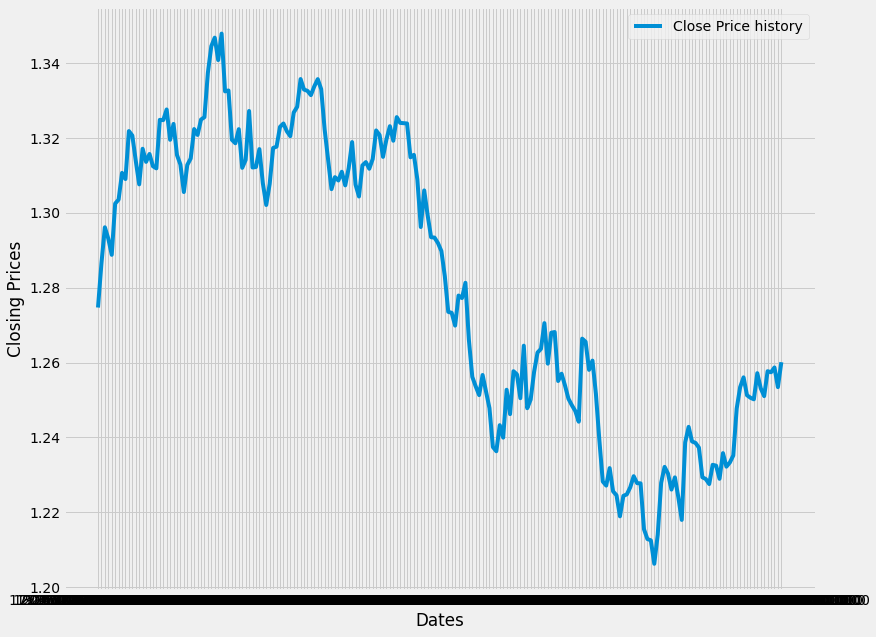

In [ ]:

plt.figure(figsize=(12,10))
plt.plot(df_plot.index, df_plot["Close"],label='Close Price history')
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.legend()

In [ ]:
#Get the feature columns for training, i am using all except the ones listed below
#feature_columns = [x for x in df.columns if x not in ['Prev_High', 'Prev_Low' ]]
#print(feature_columns)

#feature_columns = [x for x in df.columns if x in ['Open', 'High', 'Low',	'Close',	'Volume',	'Prev_Close',	'Prev_Volume',	'Open_Diff', 'OpenClose_Diff',	'EMA50', 	'ATR',	'ADX_5',	'DMP_5',	'DMN_5',	'OBVolume',	'MACD',	'MACD_signal',	'VWAP_D']]


In [ ]:
#my new training dataframe containing 24 features
#df_train = df[feature_columns].copy() 
df_train = df.copy()
df_train = df_train.astype(float)
#df_train.iloc[:,0]

In [ ]:
# Indexing Batches
df_train = df_train.sort_values(by=['Gmt time']).copy()

In [ ]:
df_train.head()

,Open,High,Low,Close,Volume,Prev_Close,EMA3,EMA8,ATR,OBVolume,RSI_14,MACD,MACD_signal
Gmt time,,,,,,,,,,,,,
01.01.2013 00:00:00.000,1.31962,1.32211,1.31898,1.31990,4106.7798,1.31963,1.320454,1.320468,0.005705,-2.712471e+06,59.908000,0.006469,0.006968
01.01.2014 00:00:00.000,1.37637,1.37754,1.37422,1.37667,2806.0601,1.37468,1.376296,1.374409,0.006322,3.338994e+06,58.847567,0.003264,0.003148
01.01.2015 00:00:00.000,1.21066,1.21082,1.20787,1.20879,5650.5498,1.20997,1.211001,1.215426,0.005651,3.766603e+05,31.390881,-0.007886,-0.006704
01.01.2017 00:00:00.000,1.05236,1.05426,1.05221,1.05282,396.6800,1.05219,1.051991,1.049426,0.008074,-5.548679e+06,49.373694,-0.004631,-0.006429
01.01.2018 00:00:00.000,1.20143,1.20173,1.20044,1.20110,7920.7500,1.20075,1.198497,1.192941,0.004807,-8.151820e+05,70.058954,0.003732,0.002095


In [ ]:
# We add a prediction column and set dummy values to prepare the data for scaling
df_train_copy = df_train.copy()
#df_train_copy['Prediction'] = df_train_copy['Close']
#df_train_copy.tail()

In [ ]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train)
df_train_scaled = scaler.transform(df_train)


# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = StandardScaler()
df_Close = pd.DataFrame(df_train_copy['Close'])
df_Close_scaled = scaler_pred.fit_transform(df_Close)

#saved_scaler = 'scaler.sav'
#saved_scaler_pred = 'scaler_pred.sav'


with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('scaler_pred.pkl', 'wb') as f:
    pickle.dump(scaler_pred, f)

                                    
#with open('joblib_RL_Model.pkl', 'rb') as f:
 #   joblib_LR_model = pickle.load(f)

#joblib.dump(scaler, saved_scaler), joblib.dump(scaler_pred, saved_scaler_pred) # save scaler to disk


(2501, 50, 13) (2501, 3)
(635, 50, 13) (635, 3)


<function matplotlib.pyplot.show(*args, **kw)>

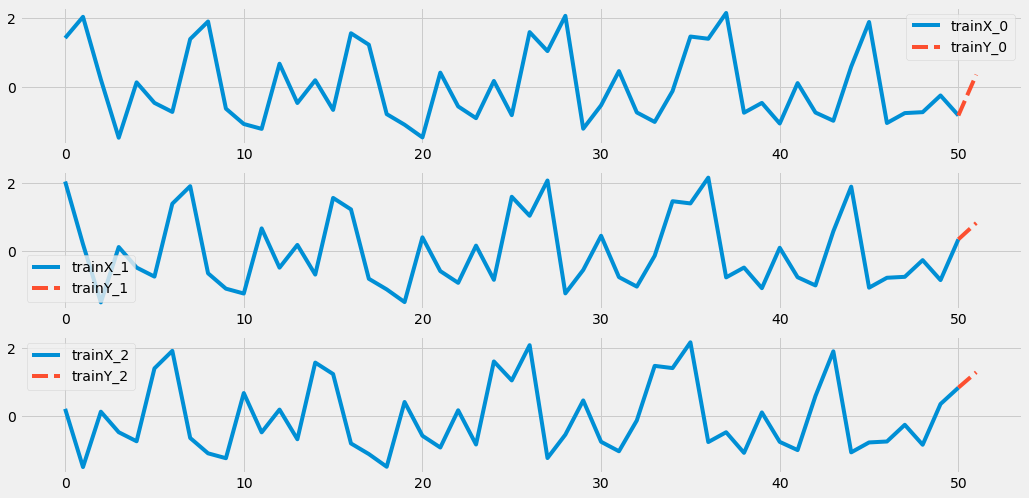

In [ ]:
import math 
import seaborn as sns

# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 50
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 3  #This is the prediction horizon; the more the less the model's accuracy 

# Prediction Index
index_Close = df_train.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(df_train_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = df_train_scaled[:train_data_length, :]
test_data = df_train_scaled[train_data_length - input_sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, input_sequence_length time steps per sample, and f features
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
trainX, trainY = partition_dataset(input_sequence_length, output_sequence_length, train_data)
testX, testY = partition_dataset(input_sequence_length, output_sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value

nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(16, 8))
for i, ax in enumerate(fig.axes):
    xtrain = pd.DataFrame(trainX[i][:,index_Close], columns={f'trainX_{i}'})
    ytrain = pd.DataFrame(trainY[i][:output_sequence_length-1], columns={f'trainY_{i}'})
    ytrain.index = np.arange(input_sequence_length, input_sequence_length + output_sequence_length-1)
    xtrain_ = pd.concat([xtrain, ytrain[:1].rename(columns={ytrain.columns[0]:xtrain.columns[0]})])
    df_merge = pd.concat([xtrain_, ytrain])
    sns.lineplot(data = df_merge, ax=ax)
plt.show

In [ ]:
model = keras.Sequential()  

model.add(Conv1D(filters=64,kernel_size=3, activation='relu', padding = 'same', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Conv1D(filters=64,kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64,kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(trainY.shape[1]))  #here we specify the number of output timesteps or features
model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(20,activation = 'relu')))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')


In [ ]:
# fit the model
#!pip install tensorflow==2.8
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/50
36/36 [==============================] - 16s 29ms/step - loss: 0.6048 - val_loss: 0.5005
Epoch 2/50
36/36 [==============================] - 1s 18ms/step - loss: 0.3457 - val_loss: 0.3371
Epoch 3/50
36/36 [==============================] - 1s 18ms/step - loss: 0.2490 - val_loss: 0.2821
Epoch 4/50
36/36 [==============================] - 1s 19ms/step - loss: 0.1787 - val_loss: 0.2526
Epoch 5/50
36/36 [==============================] - 1s 18ms/step - loss: 0.1297 - val_loss: 0.2034
Epoch 6/50
36/36 [==============================] - 1s 18ms/step - loss: 0.1092 - val_loss: 0.1922
Epoch 7/50
36/36 [==============================] - 1s 17ms/step - loss: 0.0888 - val_loss: 0.1868
Epoch 8/50
36/36 [==============================] - 1s 18ms/step - loss: 0.0741 - val_loss: 0.1654
Epoch 9/50
36/36 [==============================] - 1s 18ms/step - loss: 0.0556 - val_loss: 0.1377
Epoch 10/50
36/36 [==============================] - 1s 17ms/step - loss: 0.0423 - val_loss: 0.1304
Epoch 11

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 64)            2560      
                                                                 
 conv1d_1 (Conv1D)           (None, 48, 64)            12352     
                                                                 
 conv1d_2 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1472)              0         
                                                                 
 repeat_vector (RepeatVector  (None, 3, 1472)          0         
 )                                                      

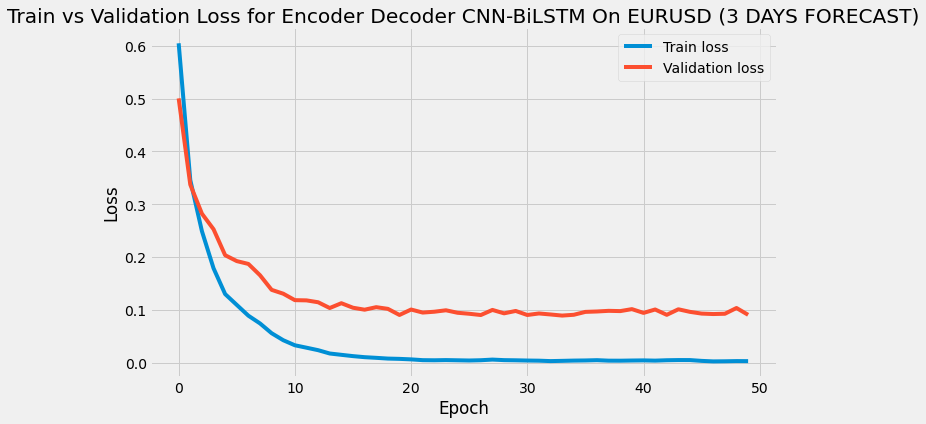

In [ ]:
#plot the loss values
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Train vs Validation Loss for Encoder Decoder CNN-BiLSTM On ' + (pair) + " (3 DAYS FORECAST)")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [ ]:
#Make prediction on the specified number of days
#model = joblib.load('/content/drive/MyDrive/Colab Notebooks/Historical FX Dataset/EncoderDecoderCNNBiLSTMmodel.sav')
prediction = model.predict(testX) 
prediction.shape

(635, 3, 1)

In [ ]:
prediction = np.squeeze(prediction) 
prediction.shape

(635, 3)

In [ ]:
#inverse the prediction
y_pred = scaler_pred.inverse_transform(prediction)

In [ ]:
y_pred.shape, y_pred.shape


((635, 3), (635, 3))

In [ ]:
#inverse transform the y_test to compate with prediction
y_test_unscaled = scaler_pred.inverse_transform(testY.reshape(-1, output_sequence_length))  #output_sequence_length is same as y_test.shape[1]
y_test_unscaled.shape

(635, 3)

In [ ]:
#checking how close prediction is to actual
print(y_pred[5,2], y_test_unscaled[5,2]) #[row,colum]
print(y_pred[3,2], y_test_unscaled[3,2])
print(y_pred[10,2], y_test_unscaled[10,2])
print(y_pred[4,2], y_test_unscaled[4,2])
print(y_pred[7,1], y_test_unscaled[7,1])
print(y_pred[1][0], y_test_unscaled[1][0])

1.3380967 1.30756
1.2186779 1.22472
1.1107584 1.13684
1.2615037 1.25033
1.3560674 1.36282
1.1227854 1.11553


In [ ]:
# Actual vs predicted testing data graph
training_data_len = int(len(df_train)*0.8)
train = df_train[:training_data_len]
valid = df_train[training_data_len:]
#valid['Predictions'] = y_pred

In [ ]:
'''plt.figure(figsize=(25,8))
plt.title('Model Plot')
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD $', fontsize=18)
plt.plot(train['Close'][-100:])
plt.plot(valid['Close'][-100:])
#plt.plot(y_pred[-100:])
plt.legend(['Train', 'Test', 'Prediction'], loc='upper right')
plt.show()'''

"plt.figure(figsize=(25,8))\nplt.title('Model Plot')\nplt.xlabel('Date', fontsize=18)\nplt.ylabel('USD $', fontsize=18)\nplt.plot(train['Close'][-100:])\nplt.plot(valid['Close'][-100:])\n#plt.plot(y_pred[-100:])\nplt.legend(['Train', 'Test', 'Prediction'], loc='upper right')\nplt.show()"

In [ ]:
# Mean Absolute Error (MAE)

MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 4)))

# Median Absolute Error (MedAE)
#MEDAE = np.median(abs(y_pred - y_test_unscaled))
#print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 4)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 4)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 4)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 4)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 4)) + ' %')

Mean Absolute Error (MAE): 0.0238
Mean Squared Error (MSE): 0.0016
Root Mean Squared Error (RMSE): 0.0398
Mean Absolute Percentage Error (MAPE): 1.9976 %
Median Absolute Percentage Error (MDAPE): 1.2454 %


In [ ]:
def prepare_df(i, x, y, y_pred_unscaled):
    #i is the index/batch number, x is the test data, y is the test label and y_pred_unscaled is the inversed prediction
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close]).rename(columns={0:'testX'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y (actual/original label/output)
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'testY'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled so there is no need to unscale again
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


In [ ]:
def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel =  "Closing_Price_Quotes")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)

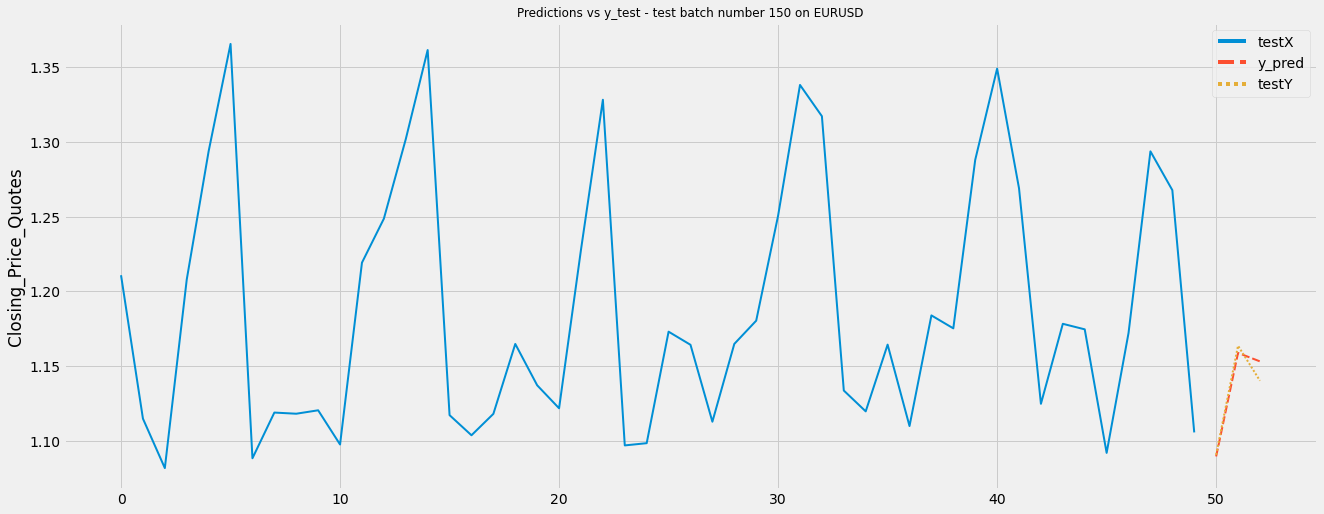

In [ ]:
# Creates a linechart for a specific test batch_number and corresponding test predictions
batch_number = 150
x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(batch_number, testX, testY, y_pred)

title = f"Predictions vs y_test - test batch number {batch_number} on " + pair

plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 

In [ ]:
'''plt.figure(figsize=(10,6))
plt.title('Actual Vs Prediction On ' + pair)
plt.xlabel('Date', fontsize=18)
plt.ylabel('USD $', fontsize=18)
plt.plot(y_pred[-100])
plt.plot(y_test_unscaled[-100])
#plt.plot(y_pred[-100:])
plt.legend(['Prediction', 'Test'], loc='upper right')
plt.show()'''

"plt.figure(figsize=(10,6))\nplt.title('Actual Vs Prediction On ' + pair)\nplt.xlabel('Date', fontsize=18)\nplt.ylabel('USD $', fontsize=18)\nplt.plot(y_pred[-100])\nplt.plot(y_test_unscaled[-100])\n#plt.plot(y_pred[-100:])\nplt.legend(['Prediction', 'Test'], loc='upper right')\nplt.show()"

In [ ]:
#SAVE THE MODEL SO WE CAN USE LATER

#saved_lstm_model = 'EncoderDecoderCNNBiLSTMmodel.sav'
#joblib.dump(model, saved_lstm_model)

#with open('model.pkl', 'wb') as f:
 #   pickle.dump(model, f)

#model.save("EncoderDecoderCNNBiLSTMmodel")


model.save('my_model.h5')

In [ ]:
#to load the saved model
#from tensorflow.keras import models
#model = models.load_model("neural_network")


# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')